### **Problem 5: A/B Testing QA Improvements**

The QA team introduced a new visual inspection method. You’ve been asked to simulate and test its impact.

**Your tasks:**

1. Randomly assign 20% of batches to group ‘A’ and the rest to group ‘B’.
2. Compare pass/fail rate between the two groups.
3. Normalize scrap rates within each group using z-score.
4. Flag ‘A’ group batches that failed despite low scrap (z < 0).
5. Calculate median scrap per group and test if ‘A’ performed better overall.
6. Plot scrap distributions (boxplot or histogram) for A vs B.
7. Summarize findings in a 3-line interpretation.

*Hint: Use `sample(frac=0.2)` and `.isin()` for assignment.*

In [352]:
import pandas as pd
import numpy as np
import re

In [353]:
data = pd.read_csv('Spool_Manufacturing_Batch_Log.csv')

In [354]:
df = pd.DataFrame(data)

In [355]:
# 1. Randomly assign 20% of batches to group ‘A’ and the rest to group ‘B’.
np.random.seed(42)

In [356]:
df['Batch Group'] = np.where(np.random.rand(len(df)) < 0.2, 'A', 'B')

In [357]:
df['Batch Group'].value_counts(normalize=True)

Batch Group
B    0.777778
A    0.222222
Name: proportion, dtype: float64

In [358]:
df['Batch Group'].value_counts()

Batch Group
B    420
A    120
Name: count, dtype: int64

In [359]:
# 2. Compare pass/fail rate between the two groups.
pass_fail_per_batch = df.groupby('Batch Group')['Pass/Fail'].value_counts().unstack()

In [360]:
pass_fail_per_batch['Fail Rate (%)'] = round(pass_fail_per_batch['Fail'] / (pass_fail_per_batch['Fail'] + pass_fail_per_batch['Pass']) * 100, 2)

In [361]:
pass_fail_per_batch['Pass Rate (%)'] = round(pass_fail_per_batch['Pass'] / (pass_fail_per_batch['Pass'] + pass_fail_per_batch['Fail']) * 100, 2)

In [362]:
pass_fail_per_batch = pass_fail_per_batch.rename_axis('Batch Group')

In [363]:
pass_fail_per_batch

Pass/Fail,Fail,Pass,Fail Rate (%),Pass Rate (%)
Batch Group,,,,
A,18,102,15.00,85.00
B,43,377,10.24,89.76


In [364]:
# 3. Normalize scrap rates within each group using z-score.
mean_scrap_rates_per_group = round(df.groupby('Batch Group')['Scrap Rate (%)'].mean(), 2)

In [365]:
mean_scrap_rates_per_group

Batch Group
A    2.25
B    2.11
Name: Scrap Rate (%), dtype: float64

In [366]:
std_scrap_rates_per_group = round(df.groupby('Batch Group')['Scrap Rate (%)'].std(), 2)

In [367]:
std_scrap_rates_per_group

Batch Group
A    1.44
B    1.32
Name: Scrap Rate (%), dtype: float64

In [368]:
batch_qty = df.groupby('Batch Group').size()

In [369]:
batch_qty

Batch Group
A    120
B    420
dtype: int64

In [370]:
scrap_rates_per_group = df.groupby('Batch Group')['Scrap Rate (%)'].sum() / batch_qty

In [371]:
scrap_rates_per_group

Batch Group
A    2.246083
B    2.109762
dtype: float64

In [372]:
summary = pd.DataFrame(
    {
        'Batch Group': df['Batch Group'],
        'Scrap Rate (%)': df['Scrap Rate (%)'],
    }
)

In [373]:
summary

,Batch Group,Scrap Rate (%)
0,B,1.79
1,B,4.28
2,B,1.65
3,B,3.15
4,A,2.81
...,...,...
535,B,2.72
536,B,0.08
537,B,1.26
538,B,1.36


In [374]:
summary['Mean Scrap Rate (%)'] = summary['Batch Group'].map(mean_scrap_rates_per_group)

In [375]:
summary['Std Scrape Rate (%)'] = summary['Batch Group'].map(std_scrap_rates_per_group)

In [376]:
summary['Normalized Scrap Rate'] = round((summary['Scrap Rate (%)'] - summary['Mean Scrap Rate (%)']) / summary['Std Scrape Rate (%)'], 2)

In [377]:
summary

,Batch Group,Scrap Rate (%),Mean Scrap Rate (%),Std Scrape Rate (%),Normalized Scrap Rate
0,B,1.79,2.11,1.32,-0.24
1,B,4.28,2.11,1.32,1.64
2,B,1.65,2.11,1.32,-0.35
3,B,3.15,2.11,1.32,0.79
4,A,2.81,2.25,1.44,0.39
...,...,...,...,...,...
535,B,2.72,2.11,1.32,0.46
536,B,0.08,2.11,1.32,-1.54
537,B,1.26,2.11,1.32,-0.64
538,B,1.36,2.11,1.32,-0.57


In [385]:
# 4. Flag ‘A’ group batches that failed despite low scrap (z < 0)
summary['Failed A'] = (summary['Batch Group'] == 'A') & (summary['Normalized Scrap Rate'] < 0)

In [387]:
summary[summary['Failed A'] == True]

,Batch Group,Scrap Rate (%),Mean Scrap Rate (%),Std Scrape Rate (%),Normalized Scrap Rate,Failed A
5,A,1.30,2.25,1.44,-0.66,True
6,A,0.87,2.25,1.44,-0.96,True
10,A,1.66,2.25,1.44,-0.41,True
14,A,1.56,2.25,1.44,-0.48,True
21,A,1.55,2.25,1.44,-0.49,True
...,...,...,...,...,...,...
472,A,0.39,2.25,1.44,-1.29,True
486,A,1.02,2.25,1.44,-0.85,True
497,A,1.58,2.25,1.44,-0.47,True
514,A,0.47,2.25,1.44,-1.24,True


In [390]:
# 5. Calculate median scrap per group and test if ‘A’ performed better overall.
median_scrap_per_group = summary.groupby('Batch Group')['Scrap Rate (%)'].median()

In [401]:
median_scrap_per_group.idxmin()

'B'

In [402]:
median_scrap_per_group

Batch Group
A    2.175
B    1.990
Name: Scrap Rate (%), dtype: float64

<Axes: title={'center': 'Histogram of Scrap Rate (%) by Batch Group'}, ylabel='Frequency'>

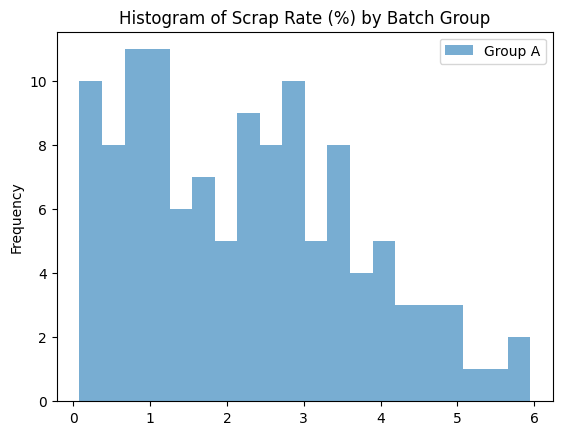

In [409]:
# 6. Plot scrap distributions (boxplot or histogram) for A vs B.
df[df['Batch Group'] == 'A']['Scrap Rate (%)'].plot(
    kind='hist',
    bins=20,
    alpha=0.6,
    label='Group A',
    title='Histogram of Scrap Rate (%) by Batch Group',
    legend=True
)

<Axes: ylabel='Frequency'>

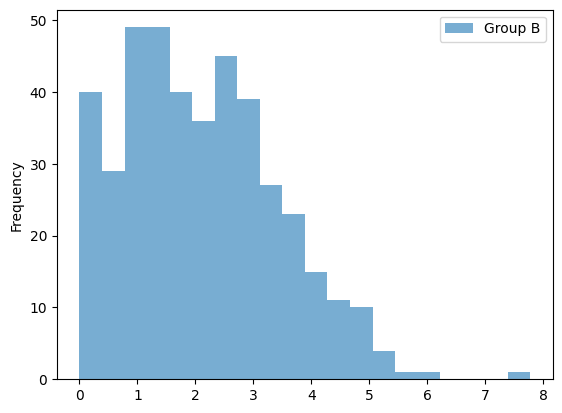

In [410]:
df[df['Batch Group'] == 'B']['Scrap Rate (%)'].plot(
    kind='hist',
    bins=20,
    alpha=0.6,
    label='Group B',
    legend=True
)

In [411]:
# 7. Summarize findings in a 3-line interpretation.

#### Interpretation Summary
Group B consistently showed a lower average and median scrap rate compared to Group A, indicating better production quality.

63 batches in Group A failed despite having a below-average (z < 0) scrap rate, suggesting non-scrap-related failure causes.

Group A's higher scrap variability and abnormal failure patterns highlight the need for further QA investigation into process or inspection issues.